# Stereo Block Matching Overview
Stereo block matching is a method used in computer vision to estimate depth by comparing two images (usually a left and right image from a stereo camera setup). The goal is to find corresponding pixels between the two images to compute disparities, which can then be used to infer depth information.


## Intermediate Step 1: Sum of Absolute Differences (SAD)
### Objective:
Implement a function that calculates the **Sum of Absolute Differences (SAD)** between two equal-sized images (or image patches).

### Concept Explanation:
- **Sum of Absolute Differences (SAD)** is a simple and commonly used metric for block matching. It computes the absolute difference between corresponding pixel values of two images or image patches and sums them up.


### Approach:
1. **Read the Images**:
    - Use a library like `OpenCV` (cv2) or `PIL` (Image) to read `nose_left.png` and `nose_right.png`.
    - Ensure the images are converted to grayscale if they are not already, as color can complicate the SAD calculation.
2. **Calculate SAD**:
    - Subtract one image from the other.
    - Take the absolute value of the result.
    - Sum all the values to get the SAD.

In [7]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

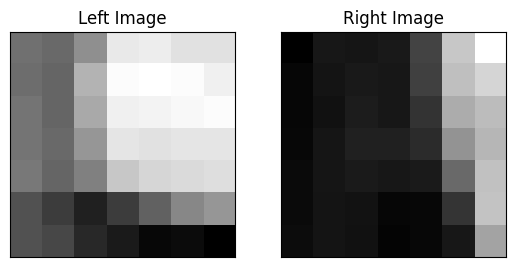

In [8]:
# Read the image
left_image = cv2.imread('nose_left.png')
right_image = cv2.imread('nose_right.png')

# Convert to grayscale
left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

# Show the images
plt.subplot(1, 2, 1)
plt.imshow(left_image_gray, cmap='gray')
plt.title('Left Image')
plt.xticks([])
plt.yticks([])
plt.subplot(1, 2, 2)
plt.imshow(right_image_gray, cmap='gray')
plt.title('Right Image')
plt.xticks([])
plt.yticks([])
plt.show()


In [9]:
def calculate_SAD(image1, image2):
    if left_image_gray.shape != right_image_gray.shape:
        raise ValueError("The two images must have the same dimensions for SAD calculation.")
    
    image1 = np.asarray(image1)
    image2 = np.asarray(image2)
    difference = np.abs(image1 - image2)
    sad = np.sum(difference)
    return sad

In [10]:
# Calculate the SAD
sad = calculate_SAD(left_image_gray, right_image_gray)
print('The SAD between the two images is:', sad)

The SAD between the two images is: 7657


## Intermediate Step 2: Matching with Multiple Templates
### Objective:
Find which of the three images (`nose1.png`, `nose2.png`, `nose3.png`) best matches `nose_left.png` using the SAD function.

### Concept Explanation:
- **Template Matching**: This involves sliding the template over an image to find the region that best matches the template.


### Approach:
1. **Read the Template and Candidate Images**:
    - Load `nose_left.png` as the template.
    - Load `nose1.png`, `nose2.png`, and `nose3.png` as candidate images.
2. **Compute SAD for Each Candidate**:
    - Use the `calculate_sad` function from Step 1 to compute the SAD between the template and each candidate image.
3. **Determine the Best Match**:
    - The candidate with the lowest SAD value is the best match.

In [11]:
# List of candidate image filenames
candidate_images_filenames = ['nose1.png', 'nose2.png', 'nose3.png']

# Read the template image
left_image_gray = cv2.imread('nose_left.png', cv2.IMREAD_GRAYSCALE)

# Initialize variables to store the best match information
best_sad = float('inf')  # Initialize with a very large value
best_match = None

# Iterate through the candidate images
for candidate_filename in candidate_images_filenames:
    # Read the candidate image
    candidate_image_gray = cv2.imread(candidate_filename, cv2.IMREAD_GRAYSCALE)
    
    # Ensure the candidate image has the same size as the template image
    if candidate_image_gray.shape != left_image_gray.shape:
        raise ValueError(f"The candidate image {candidate_filename} has a different size than the template image.")
    
    # Calculate the SAD between the template and the candidate image
    sad_value = calculate_SAD(left_image_gray, candidate_image_gray)
    print(f"SAD for {candidate_filename}: {sad_value}")
    
    # Update the best match if the current SAD is smaller
    if sad_value < best_sad:
        best_sad = sad_value
        best_match = candidate_filename

# Output the best match result
print(f'The best match is {best_match} with a SAD value of {best_sad}.')


SAD for nose1.png: 4551
SAD for nose2.png: 5613
SAD for nose3.png: 1490
The best match is nose3.png with a SAD value of 1490.


## Intermediate Step 3: Locating the Nose in a Span
### Objective:
Use the SAD function to find where the nose is located in `nose_span.png`.

### Concept Explanation:
- **1D Search Along a Row**: Since the images are rectified, corresponding features lie along the same row. You can slide the template horizontally across the span to find the best match.



### Approach:
1. **Read the Template and Span Image**:
    - Load `nose_left.png` as the template.
    - Load `nose_span.png` as the image where you need to find the nose.
2. **Sliding Window**:
    - Loop over the possible horizontal positions in `nose_span.png` where the template can fit.
    - At each position, extract a patch the same size as the template.
    - Compute the SAD between the template and the patch.
3. **Record the Position with the Lowest SAD**:
    - Keep track of the position (horizontal index) where the SAD is minimized.

In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

%matplotlib qt

# Read the template (nose_left.png) and the larger span image (nose_span.png)
template_image = cv2.imread('nose_left.png', cv2.IMREAD_GRAYSCALE)
span_image = cv2.imread('nose_span.png', cv2.IMREAD_GRAYSCALE)

# Check if both images were loaded successfully
if template_image is None or span_image is None:
    raise ValueError("One or both images could not be loaded. Check file paths.")

# Get the dimensions of the template
template_height, template_width = template_image.shape

# Ensure the span image is wide enough for the template
if span_image.shape[1] < template_width:
    raise ValueError("The span image is not wide enough to fit the template.")

# Convert span image to RGB so colors can be drawn on top
span_image_rgb = cv2.cvtColor(span_image, cv2.COLOR_GRAY2RGB)

# Initialize variables to track the best match
best_sad = float('inf')  # Large initial value
best_x = -1  # Initial position for the best match

# Prepare the plot for visualization
plt.ion()  # Turn on interactive mode to update the plot in real time
fig, ax = plt.subplots()  # Create a new figure for the external window

# Perform sliding window search along the row of the span image
for x in range(span_image_rgb.shape[1] - template_width + 1):
    # Extract a patch from the span image that matches the template size
    patch = span_image[0:template_height, x:x+template_width]
    
    # Calculate the SAD between the template and the current patch
    sad_value = calculate_SAD(template_image, patch)
    
    # Update the best match if a lower SAD is found
    if sad_value < best_sad:
        best_sad = sad_value
        best_x = x
    
    # Visualization: Plot the span image and highlight the current window
    span_image_copy = span_image_rgb.copy()  # Make a copy of the RGB image
    
    # Draw a red rectangle around the current patch
    cv2.rectangle(span_image_copy, (x, 0), (x+template_width, template_height), (255, 0, 0), 2)  # Red color in RGB
    
    # Clear the previous plot and show the current one
    ax.clear()
    ax.imshow(span_image_copy)  # Remove 'cmap' to show the image in RGB
    ax.set_title(f'Current position: {x}, SAD: {sad_value}')
    plt.draw()
    plt.pause(0.05)  # Pause to create an animation effect

# Once the process is done, highlight the best match with a green rectangle
span_image_copy = span_image_rgb.copy()
cv2.rectangle(span_image_copy, (best_x, 0), (best_x+template_width, template_height), (0, 255, 0), 2)  # Green color in BGR

# Show the final result
ax.clear()
ax.imshow(span_image_copy)
ax.set_title(f'Best match at x={best_x} with SAD={best_sad}')
plt.draw()
plt.ioff()  # Turn off interactive mode
plt.show()


## Full Template Matching Implementation (Challenge)
### Objective:
Implement a full template matching function that computes the **disparity map** for `tsukuba_left.png` and `tsukuba_right.png`.

### Concept Explanation:
- **Disparity Map**: A map that represents the displacement (disparity) of pixels between the left and right images.
- **Block Matching Algorithm**: For each block (sub-image) in the left image, find the best matching block in the right image within a certain search range.


### Approach:
1. **Read the Stereo Images**:
    - Load `tsukuba_left.png` and `tsukuba_right.png`.
    - Convert them to grayscale if necessary.
2. **Set Parameters**:
    - Define the block (template) size, e.g., 7x7.
    - Define the maximum disparity (search range).
3. **Initialize the Disparity Map**:
    - Create an empty array to store disparity values, the same size as the input images.
4. **Iterate Over Each Pixel (excluding borders)**:
    - For each pixel position `(y, x)` in the left image:
        - Extract the template/block centered at `(y, x)`.
        - Define the corresponding row in the right image.
        - Search within the defined disparity range along the row in the right image.
        - For each candidate position in the right image:
            - Extract the matching block.
            - Compute the SAD between the template and the candidate block.
            - Record the disparity (difference in x-coordinate) that gives the minimum SAD.
5. **Store the Disparity Values**:
    - Update the disparity map with the found disparity for each pixel.
6. **Post-Processing (Optional)**:
    - Apply filtering to the disparity map to reduce noise.

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the stereo images (assuming they are grayscale)
left_image = cv2.imread('tsukuba_left.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('tsukuba_right.png', cv2.IMREAD_GRAYSCALE)

# Check if images were loaded correctly
if left_image is None or right_image is None:
    raise ValueError("One or both stereo images could not be loaded.")

# Set block size and maximum disparity
block_size = 7  # Template size
max_disparity = 16  # Maximum number of pixels to search in the right image

# Initialize the disparity map (same size as the input images)
disparity_map = np.zeros(left_image.shape, dtype=np.float32)

# Compute the padding size based on block size
pad_size = block_size // 2

# Pad both images to handle edge pixels
left_image_padded = cv2.copyMakeBorder(left_image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, 0)
right_image_padded = cv2.copyMakeBorder(right_image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, 0)

# Iterate over each pixel in the left image (excluding the borders)
for y in range(pad_size, left_image.shape[0] - pad_size):
    for x in range(pad_size, left_image.shape[1] - pad_size):
        # Extract the block from the left image
        left_block = left_image_padded[y-pad_size:y+pad_size+1, x-pad_size:x+pad_size+1]

        # Initialize variables to store the best match
        best_sad = float('inf')  # Large initial SAD value
        best_disparity = 0  # Best disparity

        # Search for the best match within the disparity range in the right image
        for d in range(max_disparity):
            # Ensure the candidate block is within image bounds
            if x - d < pad_size:
                break

            # Extract the block from the right image at disparity d
            right_block = right_image_padded[y-pad_size:y+pad_size+1, (x-d)-pad_size:(x-d)+pad_size+1]

            # Compute the SAD (Sum of Absolute Differences) between the blocks
            sad = np.sum(np.abs(left_block - right_block))

            # Update the best match if the SAD is smaller
            if sad < best_sad:
                best_sad = sad
                best_disparity = d

        # Store the best disparity in the disparity map
        disparity_map[y, x] = best_disparity

# Normalize the disparity map to 0-255 for visualization
disparity_map_normalized = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)

# Display the disparity map
plt.imshow(disparity_map_normalized, cmap='gray')
plt.title('Disparity Map')
plt.show()


: 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the stereo images (assuming they are grayscale)
left_image = cv2.imread('tsukuba_left.png', cv2.IMREAD_GRAYSCALE)
right_image = cv2.imread('tsukuba_right.png', cv2.IMREAD_GRAYSCALE)

# Check if images were loaded correctly
if left_image is None or right_image is None:
    raise ValueError("One or both stereo images could not be loaded.")

# Set block size and maximum disparity
block_size = 7  # Template size
max_disparity = 16  # Maximum number of pixels to search in the right image

# Initialize the disparity map (same size as the input images)
disparity_map = np.zeros(left_image.shape, dtype=np.float32)

# Compute the padding size based on block size
pad_size = block_size // 2

# Pad both images to handle edge pixels
left_image_padded = cv2.copyMakeBorder(left_image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, 0)
right_image_padded = cv2.copyMakeBorder(right_image, pad_size, pad_size, pad_size, pad_size, cv2.BORDER_CONSTANT, 0)

# Initialize a figure for visualization
plt.ion()  # Interactive mode
fig, ax = plt.subplots(1, 3, figsize=(12, 4))  # Create 3 subplots for visualization

# Define the zoom window size
zoom_size = 50  # Adjust this value as needed

# Main loop to compute disparity map
for y in range(pad_size, left_image.shape[0] - pad_size):
    for x in range(pad_size, left_image.shape[1] - pad_size):
        # Extract the block from the left image
        left_block = left_image_padded[y-pad_size:y+pad_size+1, x-pad_size:x+pad_size+1]

        # Initialize variables to store the best match
        best_sad = float('inf')  # Large initial SAD value
        best_disparity = 0  # Best disparity

        # Search for the best match within the disparity range in the right image
        for d in range(max_disparity):
            # Ensure the candidate block is within image bounds
            if x - d < pad_size:
                break

            # Extract the block from the right image at disparity d
            right_block = right_image_padded[y-pad_size:y+pad_size+1, (x-d)-pad_size:(x-d)+pad_size+1]

            # Compute the SAD (Sum of Absolute Differences) between the blocks
            sad = np.sum(np.abs(left_block - right_block))

            # Update the best match if the qSAD is smaller
            if sad < best_sad:
                best_sad = sad
                best_disparity = d

            # Visualization: Update every time a block is compared
            # Determine the coordinates for the zoomed-in region
            y_min = max(y - zoom_size // 2, 0)
            y_max = min(y + zoom_size // 2, left_image.shape[0])
            x_min = max(x - zoom_size // 2, 0)
            x_max = min(x + zoom_size // 2, left_image.shape[1])

            # Crop the images to the zoomed-in region
            left_zoom = left_image[y_min:y_max, x_min:x_max]
            right_x_min = x_min - best_disparity
            right_x_max = x_max - best_disparity

            # Ensure indices are within bounds for the right image
            if right_x_min < 0:
                right_x_min = 0
            if right_x_max > right_image.shape[1]:
                right_x_max = right_image.shape[1]

            right_zoom = right_image[y_min:y_max, right_x_min:right_x_max]

            # Clear previous plots
            ax[0].clear()
            ax[1].clear()

            # Show the zoomed-in left and right images
            ax[0].imshow(left_zoom, cmap='gray')
            ax[0].set_title(f"Left Image Zoomed Window: (y={y}, x={x})")

            ax[1].imshow(right_zoom, cmap='gray')
            ax[1].set_title(f"Right Image Zoomed Window (Disparity={d})")

            # Compute rectangle positions in the cropped images
            left_rect_x = (x - pad_size) - x_min
            left_rect_y = (y - pad_size) - y_min

            right_rect_x = (x - best_disparity - pad_size) - right_x_min
            right_rect_y = (y - pad_size) - y_min

            # Draw rectangles on the images to represent the blocks
            left_rect = plt.Rectangle((left_rect_x, left_rect_y), block_size, block_size,
                                      edgecolor='red', facecolor='none')
            ax[0].add_patch(left_rect)

            right_rect = plt.Rectangle((right_rect_x, right_rect_y), block_size, block_size,
                                       edgecolor='red', facecolor='none')
            ax[1].add_patch(right_rect)

            # Show the updated disparity map
            disparity_map[y, x] = best_disparity

            ax[2].clear()
            ax[2].imshow(disparity_map, cmap='gray')
            ax[2].set_title(f"Disparity Map (y={y}, x={x})")

            # Display the disparity value
            plt.suptitle(f"Current Disparity: {best_disparity}")
            plt.draw()
            plt.pause(0.05)  # Small pause to visualize updates

# Final disparity map visualization
plt.ioff()
plt.show()

# Normalize the disparity map to 0-255 for visualization
disparity_map_normalized = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)

# Display the final disparity map
plt.imshow(disparity_map_normalized, cmap='gray')
plt.title('Final Disparity Map')
plt.show()
